# Limpieza de datos

Para los datos del Estado de México que son historicos se tiene que realizar lo siguiente:


*  Eliminar columnas: Precipitación, Evaporación
*  Si la temperatura máxima y mínima en algún registro es nulo, eliminarlo
*  Si es nulo alguno de los dos valores de temperatura, calcular el promedio con las dos temperaturas anteriores y las dos temperaturas posteriores



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import chardet

import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import os

In [3]:
# Autenticación y creación del cliente PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#Descarga los archivos y los convierte en dataframes

# ID de la carpeta compartida que deseas listar
carpeta_id = '1pvA46f64RB_3CpOXZQ68iMGgWBZkkqs-'

# Lista para almacenar los nombres de los archivos
files_dataframes = []

# Obtener la lista de archivos en la carpeta compartida
file_list = drive.ListFile({'q': "'{}' in parents".format(carpeta_id)}).GetList()

for archivo in file_list:
    try:
        # Descargar el archivo y guardarlo en el directorio actual
        archivo.GetContentFile(archivo['title'])
        # Leer el archivo descargado y crear un DataFrame
        df = pd.read_excel(archivo['title'])
        # Agregar el DataFrame al array
        files_dataframes.append(df)
        print("Archivo descargado y DataFrame creado:", archivo['title'])
    except Exception as e:
        print("Error al descargar y crear DataFrame para el archivo:", archivo['title'])
        print(e)

Archivo descargado y DataFrame creado: Valle_utf8.xlsx
Archivo descargado y DataFrame creado: PueblaSan Nicolas (1).xlsx
Archivo descargado y DataFrame creado: Manuel_utf8.xlsx
Archivo descargado y DataFrame creado: Atlacomulco_utf8.xlsx
Archivo descargado y DataFrame creado: Ixtapaluca_utf8.xlsx
Archivo descargado y DataFrame creado: Oro_utf8.xlsx
Archivo descargado y DataFrame creado: Toluca_utf8.xlsx
Archivo descargado y DataFrame creado: Edo Amecameca.xlsx
Archivo descargado y DataFrame creado: PueblaSan Nicolas.xlsx
Archivo descargado y DataFrame creado: laguna.xlsx
Archivo descargado y DataFrame creado: cerro.xlsx
Archivo descargado y DataFrame creado: nevado.xlsx


In [ ]:
files_dataframes[0].dtypes

Fecha                datetime64[ns]
Precipitacion               float64
Evaporacion                  object
TemperaturaMaxima           float64
TemperaturaMinima           float64
dtype: object

In [ ]:
print(files_dataframes[0].Fecha.max())
print(files_dataframes[0].Fecha.min())
print(files_dataframes[0].tail())

31/12/2020
----------
            Fecha Precipitacion Evaporacion TemperaturaMaxima  \
10619  28/07/2021      0            0.7               25        
10620  29/07/2021      4.8          5                 25        
10621  30/07/2021      27           1.2               23        
10622  31/07/2021      2            3.8               24        
10623  ----------      --------     -------           -------   

      TemperaturaMinima  
10619              14.5  
10620              15    
10621              15    
10622              14.5  
10623              ----  


In [5]:
def calcular_valor(fila):
  if fila['Precipitacion'] == 0.0:
    return 0
  elif fila['Precipitacion'] > 0.0 and fila['Precipitacion'] < 15.0:
    return 1
  elif (fila['Precipitacion'] > 15.0 and fila['Precipitacion'] < 30.0):
    return 2
  else:
    return 3

In [6]:
def limpiar_datos(df):
    columnas = ['Precipitacion', 'TemperaturaMaxima', 'TemperaturaMinima']
    df[columnas] = df[columnas].apply(pd.to_numeric, errors="coerce")
    df['Fecha'] = pd.to_datetime(df['Fecha'], errors="coerce")
    df = df.drop('Evaporacion', axis = 1)
    df = df.dropna(subset=['TemperaturaMaxima','TemperaturaMinima'], how = "all")

    df[columnas] = df[columnas].interpolate(method='linear', limit_direction='both')
    df['Categoria'] = df.apply(calcular_valor, axis = 1)

    return df

In [7]:
# Crea un ThreadPoolExecutor con 4 hilos
with ThreadPoolExecutor(max_workers=4) as executor:
    # Ejecuta la función de limpieza para cada archivo
    resultados = list(executor.map(limpiar_datos, files_dataframes))

df_final = pd.concat(resultados, ignore_index = True)

<ipython-input-6-468ef62465d0>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Fecha'] = pd.to_datetime(df['Fecha'], errors="coerce")
<ipython-input-6-468ef62465d0>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Fecha'] = pd.to_datetime(df['Fecha'], errors="coerce")
<ipython-input-6-468ef62465d0>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Fecha'] = pd.to_datetime(df['Fecha'], errors="coerce")
<ipython-input-6-468ef62465d0>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead 

In [8]:
df_final.to_csv('resultados_modulos.csv', index=False)
# Guarda el DataFrame en un archivo CSV dentro de la carpeta compartida
#final_df.to_csv(os.path.join(shared_folder_path, 'resultados_modulos.csv'), index=False)

print(df_final.Fecha.max())

2022-12-31 00:00:00


In [ ]:
print(df_final.isna().sum())

Fecha                     0
Precipitacion             0
TemperaturaMaxima         0
TemperaturaMinima         0
Categoria                 0
Evaporacion          198298
dtype: int64


In [ ]:
!rm -R -f Untitled\ Folder

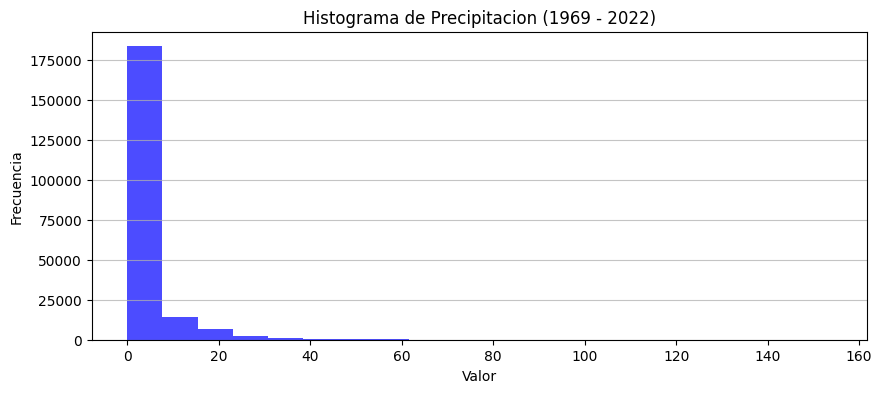

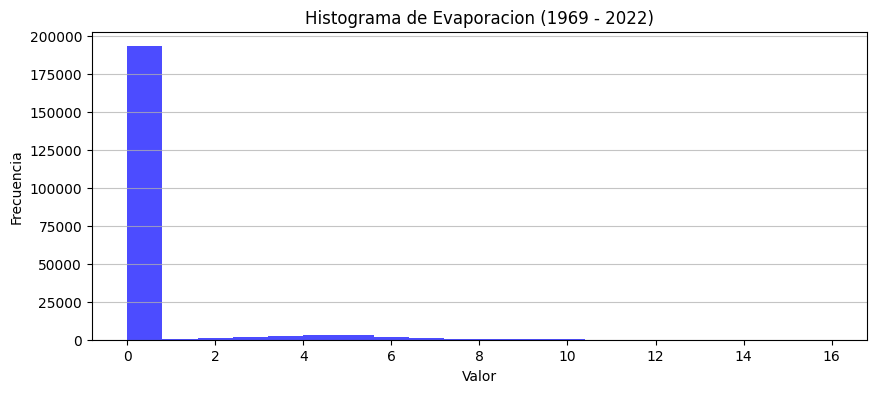

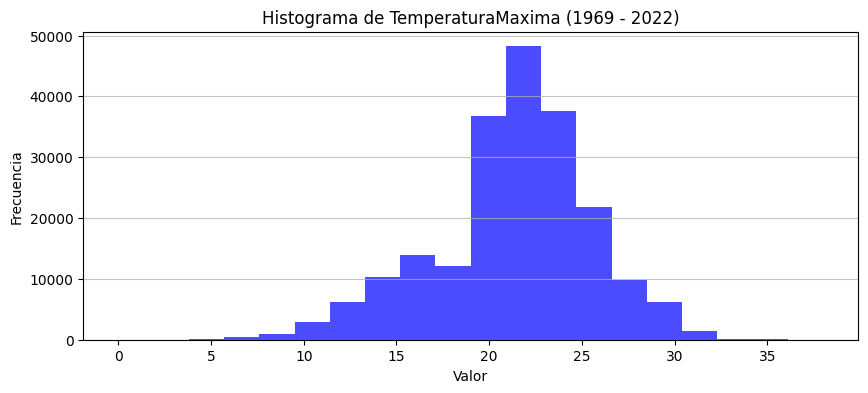

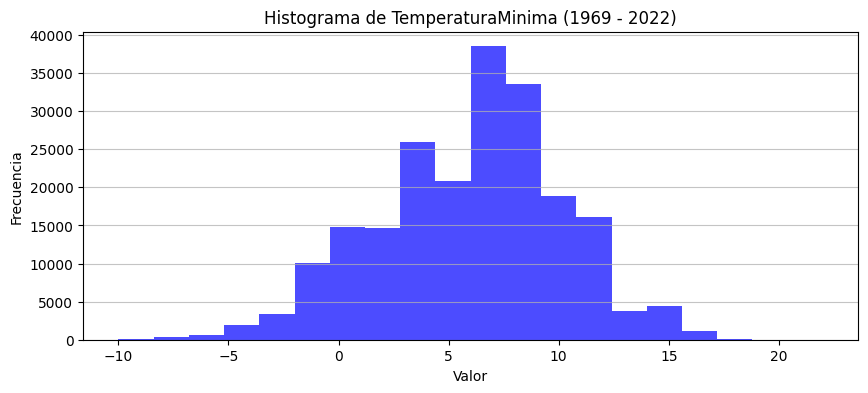

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el DataFrame si no está cargado
# df_final = pd.read_csv('ruta_a_tu_archivo.csv')

# Convertir la columna 'Evaporacion' a numérico, reemplazando NaN por 0
df_final['Evaporacion'] = pd.to_numeric(df_final['Evaporacion'], errors='coerce').fillna(0)

# Asegúrate de que la columna 'Fecha' sea del tipo datetime.
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])

# Ordenar el DataFrame por la columna 'Fecha' en orden ascendente.
df_final.sort_values('Fecha', ascending=True, inplace=True)

# Filtrar el DataFrame por el rango de fechas deseado (1969 a 2022).
df_final = df_final[(df_final['Fecha'].dt.year >= 1969) & (df_final['Fecha'].dt.year <= 2022)]

# Definir las columnas numéricas para las cuales se creará un histograma.
numeric_columns = ['Precipitacion', 'Evaporacion', 'TemperaturaMaxima', 'TemperaturaMinima']

# Crear un histograma para cada columna numérica.
for column in numeric_columns:
    plt.figure(figsize=(10, 4))
    plt.hist(df_final[column], bins=20, alpha=0.7, color='blue')
    plt.title(f'Histograma de {column} (1969 - 2022)')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', alpha=0.75)
    plt.show()


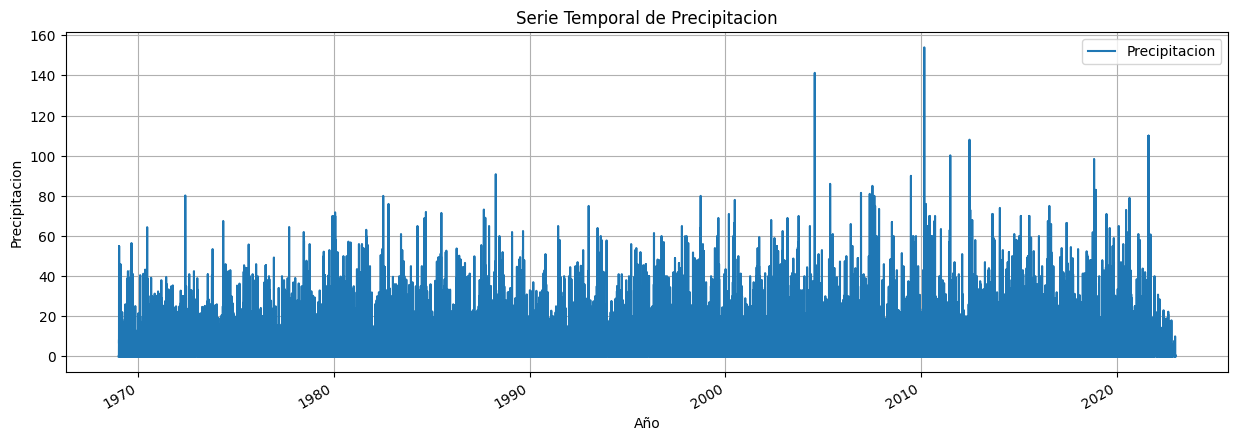

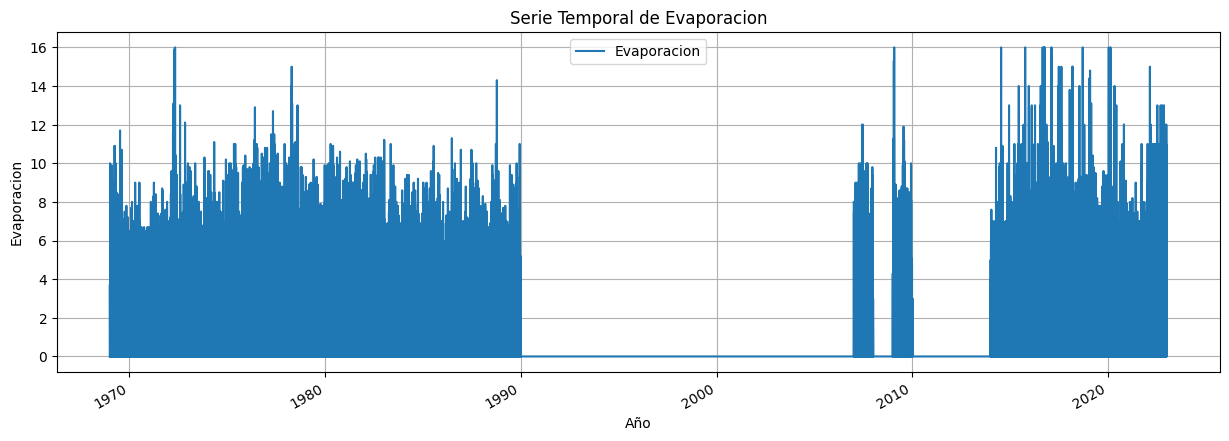

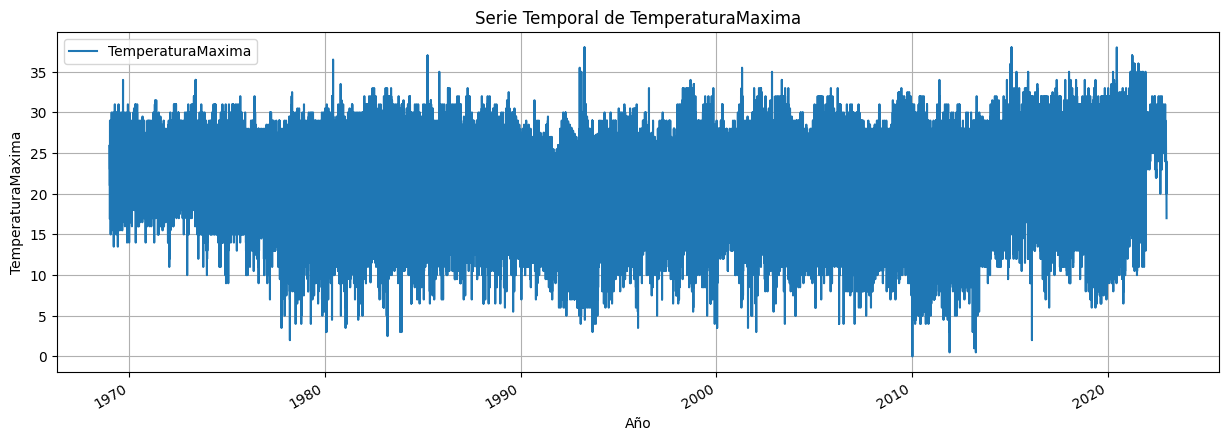

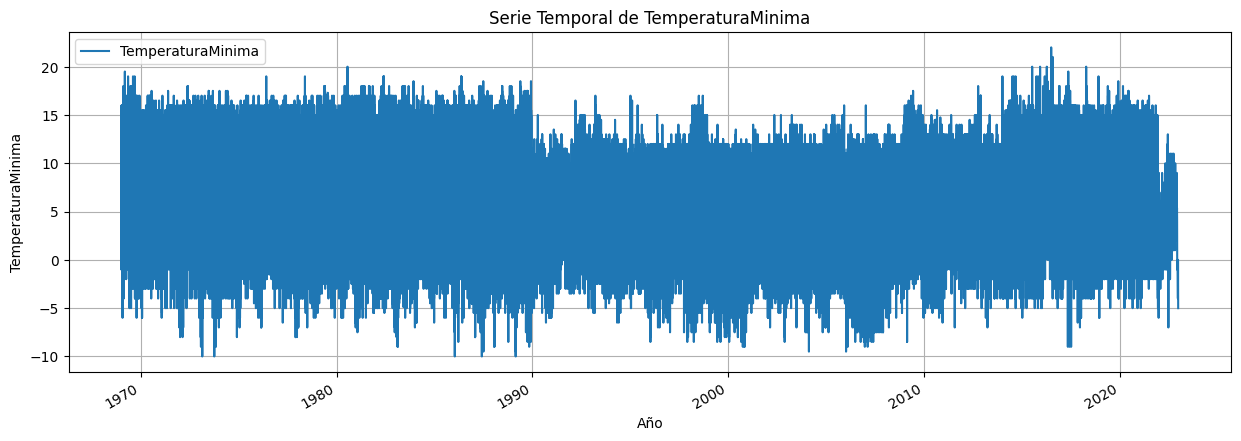

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asegúrate de que df_final es tu DataFrame y tiene los datos cargados.
# df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])

# Ordena el DataFrame por la columna 'Fecha' en orden ascendente.
df_final.sort_values('Fecha', ascending=True, inplace=True)

# Convertir 'Evaporacion' a numérico, reemplazando NaN por 0.
df_final['Evaporacion'] = pd.to_numeric(df_final['Evaporacion'], errors='coerce').fillna(0)

# Definir las columnas numéricas para las cuales se creará gráficos de líneas.
numeric_columns = ['Precipitacion', 'Evaporacion', 'TemperaturaMaxima', 'TemperaturaMinima']

# Crear un gráfico de línea para cada columna numérica.
for column in numeric_columns:
    plt.figure(figsize=(15, 5))
    plt.plot(df_final['Fecha'], df_final[column], label=column)

    # Configurar el eje X para mostrar una etiqueta cada 10 años.
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Rotar y alinear las etiquetas de fecha.
    plt.gcf().autofmt_xdate()

    plt.title(f'Serie Temporal de {column}')
    plt.xlabel('Año')
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
df_final.Evaporacion.isna().sum()

198298